# Quantization of Signals

*This jupyter/Python notebook is part of a [collection of notebooks](../index.ipynb) in the masters module [Digital Signal Processing](http://www.int.uni-rostock.de/Digitale-Signalverarbeitung.48.0.html), Comunications Engineering, Universität Rostock. Please direct questions and suggestions to <mailto:Sascha.Spors@uni-rostock.de>.*

## Oversampling

[Oversampling](https://en.wikipedia.org/wiki/Oversampling) is a technique which is applied in [analog-to-digital converters](https://en.wikipedia.org/wiki/Analog-to-digital_converter) to lower the average power of the quantization error. It requires a joint consideration of sampling and quantization.

### Ideal Analog-to-Digital Conversion

Let's consider the ideal sampling of a signal followed by its quantization, as given by the following block diagram

![Ideal analog to digital conversion of a signal](ideal_ADC.png)

Ideal sampling is modeled by multiplying the continuous signal $x(t)$ with a series of equidistant Dirac functions, resulting in the discrete signal $x[k] = x(k T)$ where $T$ denotes the sampling interval. The discrete signal $x[k]$ is then quantized. The output of the ideal analog-to-digital converter is the quantized discrete signal $x_\text{Q}[k]$.

### Nyquist Sampling

Sampling of the continuous signal $x(t)$ leads to repetitions of the spectrum $X(j \omega) = \mathcal{F} \{ x(t) \}$ at multiples of $\omega_\text{S} = \frac{2 \pi}{T}$. We limit ourselves to a continuous real-valued $x(t) \in \mathbb{R}$, band-limted signal $| X(j \omega) | = 0$ for $|\omega| > \omega_\text{C}$ where $\omega_\text{C}$ denotes its cut-off frequency. The spectral repetitions due to sampling do not overlap if the [sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) $\omega_\text{S} \geq  2 \cdot \omega_\text{C}$ is fulfilled. In the case of Nyquist (critical) sampling, the sampling frequency is chosen as $\omega_\text{S} =  2 \cdot \omega_\text{C}$.

### Oversampling

The basic idea of oversampling is to sample the input signal at frequencies which are significantly higher than the Nyquist criterion dictates. After quantization, the signal is low-pass filtered by a discrete filter $H_\text{LP}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$ and resampled back to the Nyquist rate. In order to avoid aliasing due to the resampling this filter has to be chosen as an ideal low-pass

$$ H_\text{LP}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \text{rect} \left( \frac{\Omega}{2 \, \Omega_\text{C}} \right) $$

where $\Omega_\text{C} = \omega_\text{C} \cdot T$. For an oversampling of factor $L \in \mathbb{Z}$ we have $\omega_\text{S} = L \cdot 2 \omega_\text{C}$. For this case, the resampling can be realized by keeping only every $L$-th sample which is known as decimation. The following block diagram illustrates the building blocks of oversampled digital-to-analog conversion, $\downarrow L$ denotes decimation by a factor of $L$

![Oversampling ideal analog to digital converter](oversampling.png)

In order the conclude on the benefits of oversampling we have to derive the average power of the overall quantization error. According to our [model of the quantization error](linear_uniform_quantization_error.ipynb#Model-for-the-Quantization-Error), the quantization error $e[k]$ can be modeled as uniformly distributed white noise. Its power spectral density (PSD) is given as

$$ \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \frac{Q^2}{12} $$

where $Q$ denotes the quantization step. Before the discrete low-pass filter $H_\text{LP}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$, the power of the quantization error is uniformly distributed over the entire frequency range $-\pi < \Omega \leq \pi$. However, after the ideal low-pass filter the frequency range is limited to $- \frac{\pi}{L} < \Omega \leq \frac{\pi}{L}$. The average power of the quantization error is then given as

$$ \sigma_{e, \text{LP}}^2 = \frac{1}{2 \pi} \int\limits_{- \frac{\pi}{L}}^{\frac{\pi}{L}} \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega})  \; \mathrm{d}\Omega = \frac{1}{L} \cdot \frac{Q^2}{12}$$

The average power $\sigma_x^2$ of the sampled signal $x[k]$ is not affected, since the cutoff frequency of the low-pass filter has been chosen as the upper frequency limit $\omega_\text{C}$ of the input signal $x(t)$. 

In order to calculate the SNR of the oversampled analog-to-digital converter we assume that the input signal is drawn from a uniformly distributed zero-mean random process with $|x[k]| < x_\text{max}$. With the results from our discussion of [linear uniform quantization](linear_uniform_quantization_error.ipynb#Uniformly-Distributed-Signal) and $\sigma_{e, \text{LP}}^2$ from above we get

$$ SNR = 10 \cdot \log_{10} \left( 2^{2 w} \right) + 10 \cdot \log_{10} \left( L \right) \approx 6.02 \, w + 10 \cdot \log_{10} \left( L \right) \quad \text{in dB} $$

where $w$ denotes the number of bits used for a binary representation of the quantization index. Hence, oversampling by a factor of $L$ brings a plus of $10 \cdot \log_{10} \left( L \right)$ dB in terms of SNR. For instance, an oversampling by a factor of $L = 4$ results in a SNR which is approximately 6 dB higher. For equal SNR the quantization step $Q$ can be chosen larger. In terms the of wordlength of a quantizer this accounts to a reduction by one bit. Consequently, there is a trade-off between accuracy of the quantizer and its sampling frequency.

### Example

The following numerical simulation illustrates the benefit in terms of SNR for an oversampled linear uniform quantizer with $w = 16$ for the quantization of the harmonic signal $x[k] = \cos[\Omega_0 k]$.

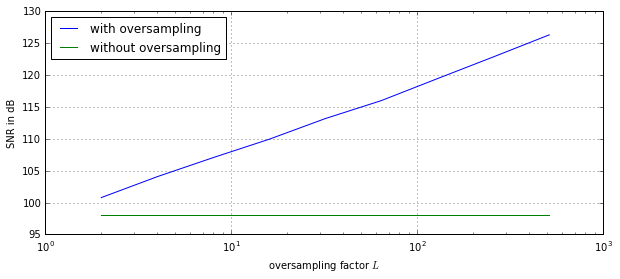

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

w = 16  # wordlength of the quantized signal
L = 2**np.arange(1,10)  # oversampling factors

N = 8192  # length of signals
Om0 = 100*2*np.pi/N  # frequency of harmonic signal
Q = 1/(2**(w-1))  # quantization step


def uniform_midtread_quantizer(x, Q):
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ

def SNR_oversampled_ADC(L):
    x = (1-Q)*np.cos(Om0*np.arange(N))
    xu = (1-Q)*np.cos(Om0*np.arange(N*L)/L)
    # quantize signal
    xQu = uniform_midtread_quantizer(xu, Q)
    # low-pass filtering and decimation
    xQ = sig.resample(xQu, N)
    # estimate SNR
    e = xQ - x
    
    return 10*np.log10((np.var(x)/np.var(e)))


# compute SNR for oversampled ADC
SNR = [SNR_oversampled_ADC(l) for l in L]

# plot result
plt.figure(figsize=(10, 4))
plt.semilogx(L, SNR, label='with oversampling')
plt.plot(L, (6.02*w+1.76)*np.ones(L.shape), label='without oversampling' )
plt.xlabel(r'oversampling factor $L$')
plt.ylabel(r'SNR in dB')
plt.legend(loc='upper left')
plt.grid()

**Exercise**

* What SNR can be achieved for an oversampling factor of $L=16$?
* By how many bits could the word length $w$ be reduced in order to gain the same SNR as without oversampling?

### Anti-Aliasing Filter

Besides an increased SNR, oversampling has also another benefit. In order to ensure that the input signal $x(t)$ is band-limited before sampling, a low-pass filter $H_\text{LP}(\mathrm{j}\,\omega)$ is applied in typical analog-to-digital converters. This is illustrated in the following

![Oversampling ideal analog to digital converter with anti-aliasing filter](oversampling_anti_aliasing.png)

The filter $H_\text{LP}(\mathrm{j}\,\omega)$ is also known as [anti-aliasing filter](https://en.wikipedia.org/wiki/Anti-aliasing_filter). The ideal low-pass filter is given as $H_\text{LP}(\mathrm{j}\,\omega) = \text{rect}\left( \frac{\omega}{\omega_\text{S}}  \right)$. The ideal $H_\text{LP}(\mathrm{j}\,\omega)$ can only be approximated in the analog domain. Since the sampling rate is higher than the Nyquist rate, there is no need for a steep slope of the filter in order to avoid aliasing. However, the pass-band of the filter within $|\omega| < |\omega_\text{C}|$ has to be flat. 

Before decimation, the discrete filter $H_\text{LP}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$ has to remove the spectral contributions that may lead to aliasing. However, a discrete filter $H_\text{LP}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$ with steep slope can be realized much easier than in the analog domain.

**Copyright**

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>